In [84]:
import pickle
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras_tqdm import TQDMNotebookCallback

from sklearn.metrics import accuracy_score

In [144]:
def train_model(image_resize, Nber_of_breeds, dropout, fully_connected_nodes, learning_rate, epochs, batch_size):
    # Print model name
    print("X_train_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl")

    # Load data
    X_train = pickle.load(open("pickles/X_train_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
    X_test = pickle.load(open("pickles/X_test_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
    y_train = pickle.load(open("pickles/y_train_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
    y_test = pickle.load(open("pickles/y_test_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
    labels_name = pickle.load(open("pickles/labels_name_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))

    # Create model
    model = Sequential()
    #add model layers
    model.add(Conv2D(32, kernel_size=5, activation='relu', input_shape=(image_resize,image_resize,3)))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    model.add(Conv2D(64, kernel_size=4, activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    model.add(Conv2D(128, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    # model.add(Conv2D(256, kernel_size=3, activation='relu'))
    # model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(fully_connected_nodes, activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(Nber_of_breeds, activation='softmax'))

    # Compile model
    model_name = "model_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + "breeds_" + str(dropout) + "dropout_" + str(learning_rate) + "lr_" + str(fully_connected_nodes) + "fc_" + str(batch_size) + "batch"
    print(model_name)
    checkpointer = ModelCheckpoint(filepath="models/" + model_name + ".hdf5", verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    adam = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, early_stopping, TQDMNotebookCallback()], verbose=0)

In [152]:
# Data params
image_resize = 60
Nber_of_breeds = 8

# Model params
dropout = 0.3
fully_connected_nodes = 500
learning_rate=0.0005
# learning_rates= [0.0001, 0.0005, 0.001]

# Training params
epochs = 50
batch_size = 20

In [153]:
train_model(image_resize, Nber_of_breeds, dropout, fully_connected_nodes, learning_rate, epochs, batch_size)

X_train_60x60_8.pkl
model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.04987, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.04987 to 1.86193, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.86193 to 1.72537, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.72537 to 1.65545, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss did not improve from 1.65545



Epoch 00006: val_loss improved from 1.65545 to 1.61633, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00007: val_loss did not improve from 1.61633



Epoch 00008: val_loss did not improve from 1.61633



Epoch 00009: val_loss did not improve from 1.61633



Epoch 00010: val_loss did not improve from 1.61633



Epoch 00011: val_loss did not improve from 1.61633
Epoch 00011: early stopping


In [148]:
# for learning_rate in learning_rates:
#     train_model(image_resize, Nber_of_breeds, dropout, fully_connected_nodes, learning_rate, epochs, batch_size)

X_train_60x60_8.pkl
model_60x60_8breeds_0.3dropout_0.0001lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.05459, saving model to models/model_60x60_8breeds_0.3dropout_0.0001lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.05459 to 2.01035, saving model to models/model_60x60_8breeds_0.3dropout_0.0001lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 2.01035 to 1.88164, saving model to models/model_60x60_8breeds_0.3dropout_0.0001lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.88164 to 1.75453, saving model to models/model_60x60_8breeds_0.3dropout_0.0001lr_500fc_20batch.hdf5



Epoch 00005: val_loss improved from 1.75453 to 1.68463, saving model to models/model_60x60_8breeds_0.3dropout_0.0001lr_500fc_20batch.hdf5



Epoch 00006: val_loss did not improve from 1.68463



Epoch 00007: val_loss improved from 1.68463 to 1.66516, saving model to models/model_60x60_8breeds_0.3dropout_0.0001lr_500fc_20batch.hdf5



Epoch 00008: val_loss did not improve from 1.66516



Epoch 00009: val_loss improved from 1.66516 to 1.65719, saving model to models/model_60x60_8breeds_0.3dropout_0.0001lr_500fc_20batch.hdf5



Epoch 00010: val_loss improved from 1.65719 to 1.55960, saving model to models/model_60x60_8breeds_0.3dropout_0.0001lr_500fc_20batch.hdf5



Epoch 00011: val_loss did not improve from 1.55960



Epoch 00012: val_loss improved from 1.55960 to 1.55047, saving model to models/model_60x60_8breeds_0.3dropout_0.0001lr_500fc_20batch.hdf5



Epoch 00013: val_loss did not improve from 1.55047



Epoch 00014: val_loss did not improve from 1.55047



Epoch 00015: val_loss did not improve from 1.55047



Epoch 00016: val_loss did not improve from 1.55047



Epoch 00017: val_loss did not improve from 1.55047
Epoch 00017: early stopping
X_train_60x60_8.pkl
model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.06686, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.06686 to 1.85965, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.85965 to 1.71824, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.71824 to 1.69078, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss improved from 1.69078 to 1.64973, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss did not improve from 1.64973



Epoch 00007: val_loss improved from 1.64973 to 1.64592, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00008: val_loss improved from 1.64592 to 1.60256, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00009: val_loss did not improve from 1.60256



Epoch 00010: val_loss did not improve from 1.60256



Epoch 00011: val_loss did not improve from 1.60256



Epoch 00012: val_loss did not improve from 1.60256



Epoch 00013: val_loss did not improve from 1.60256
Epoch 00013: early stopping
X_train_60x60_8.pkl
model_60x60_8breeds_0.3dropout_0.001lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.05467, saving model to models/model_60x60_8breeds_0.3dropout_0.001lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.05467 to 1.80612, saving model to models/model_60x60_8breeds_0.3dropout_0.001lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.80612 to 1.76536, saving model to models/model_60x60_8breeds_0.3dropout_0.001lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.76536 to 1.70065, saving model to models/model_60x60_8breeds_0.3dropout_0.001lr_500fc_20batch.hdf5



Epoch 00005: val_loss improved from 1.70065 to 1.61040, saving model to models/model_60x60_8breeds_0.3dropout_0.001lr_500fc_20batch.hdf5



Epoch 00006: val_loss did not improve from 1.61040



Epoch 00007: val_loss did not improve from 1.61040



Epoch 00008: val_loss did not improve from 1.61040



Epoch 00009: val_loss did not improve from 1.61040



Epoch 00010: val_loss did not improve from 1.61040
Epoch 00010: early stopping


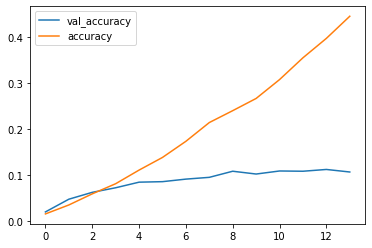

In [154]:
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.plot(history.history["accuracy"], label = "accuracy")
plt.legend();

In [156]:
X_test = pickle.load(open("pickles/X_test_" + str(size) + "x" + str(size) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
y_test = pickle.load(open("pickles/y_test_" + str(size) + "x" + str(size) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))

predictions = model.predict(X_test)

    
pred_argmax = []
for pred in predictions:
    pred_argmax.append(pred.argmax())

true_argmax = []
for pred in y_test:
    true_argmax.append(pred.argmax())

accuracy_score(pred_argmax, true_argmax)

0.35018050541516244

Loading model: model_20x20_8breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_40x40_8breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_8breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_80x80_8breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...


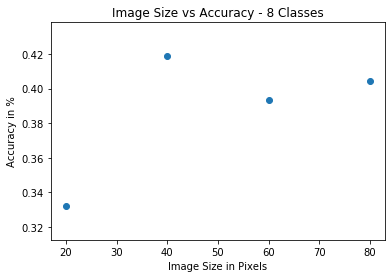

In [157]:
# Data params
image_resizes = [20, 40, 60, 80]
Nber_of_breeds = 8

# Model params
dropout = 0.3
fully_connected_nodes = 500
learning_rate=0.0001

# Training params
batch_size = 20

models = []
for size in image_resizes:
    model_name = "model_" + str(size) + "x" + str(size) + "_" + str(Nber_of_breeds) + "breeds_" + str(dropout) + "dropout_" + str(learning_rate) + "lr_" + str(fully_connected_nodes) + "fc_" + str(batch_size) + "batch"

    models.append(model_name)

accuracies = []
for size, model_name in zip(image_resizes, models):
    print("Loading model:", model_name)
    model = load_model('models/' + model_name + '.hdf5')
    
    print("Loading X_test pickle...")
    X_test = pickle.load(open("pickles/X_test_" + str(size) + "x" + str(size) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
    
    print("Loading y_test pickle...")
    y_test = pickle.load(open("pickles/y_test_" + str(size) + "x" + str(size) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
    
    print("Getting predictions...")
    predictions = model.predict(X_test)

    
    pred_argmax = []
    for pred in predictions:
        pred_argmax.append(pred.argmax())

    true_argmax = []
    for pred in y_test:
        true_argmax.append(pred.argmax())

    print("Calculating accuracy...")
    accuracies.append(accuracy_score(pred_argmax, true_argmax))
    
plt.scatter(image_resizes, accuracies);
plt.xlabel("Image Size in Pixels");
plt.ylabel("Accuracy in %");
plt.title(f"Image Size vs Accuracy - {Nber_of_breeds} Classes");

Loading model: model_60x60_4breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_8breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_16breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_32breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_64breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...


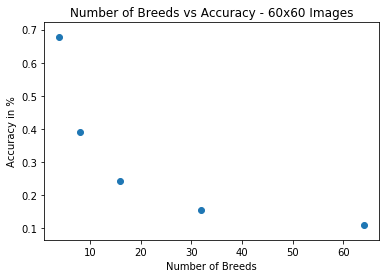

In [140]:
# Data params
size = 60
num_breeds = [4, 8, 16, 32, 64]

# Model params
dropout = 0.3
fully_connected_nodes = 500
learning_rate=0.0001

# Training params
batch_size = 20

models = []
for breed in num_breeds:
    model_name = "model_" + str(size) + "x" + str(size) + "_" + str(breed) + "breeds_" + str(dropout) + "dropout_" + str(learning_rate) + "lr_" + str(fully_connected_nodes) + "fc_" + str(batch_size) + "batch"

    models.append(model_name)

accuracies = []
for breed, model_name in zip(num_breeds, models):
    print("Loading model:", model_name)
    model = load_model('models/' + model_name + '.hdf5')
    
    print("Loading X_test pickle...")
    X_test = pickle.load(open("pickles/X_test_" + str(size) + "x" + str(size) + "_" + str(breed) + ".pkl", "rb"))
    
    print("Loading y_test pickle...")
    y_test = pickle.load(open("pickles/y_test_" + str(size) + "x" + str(size) + "_" + str(breed) + ".pkl", "rb"))
    
    print("Getting predictions...")
    predictions = model.predict(X_test)

    
    pred_argmax = []
    for pred in predictions:
        pred_argmax.append(pred.argmax())

    true_argmax = []
    for pred in y_test:
        true_argmax.append(pred.argmax())

    print("Calculating accuracy...")
    accuracies.append(accuracy_score(pred_argmax, true_argmax))
    
plt.scatter(num_breeds, accuracies);
plt.xlabel("Number of Breeds");
plt.ylabel("Accuracy in %");
plt.title(f"Number of Breeds vs Accuracy - {size}x{size} Images");

Loading model: model_60x60_8breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_8breeds_0.3dropout_0.001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...


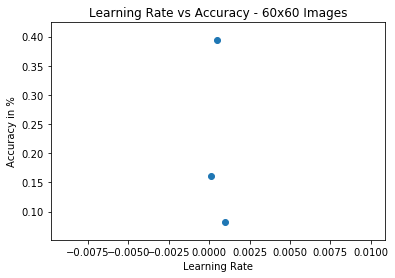

In [158]:
# Data params
size = 60
breed = 8

# Model params
dropout = 0.3
fully_connected_nodes = 500
learning_rates= [0.0001, 0.0005, 0.001]

# Training params
batch_size = 20

models = []
for learning_rate in learning_rates:
    model_name = "model_" + str(size) + "x" + str(size) + "_" + str(breed) + "breeds_" + str(dropout) + "dropout_" + str(learning_rate) + "lr_" + str(fully_connected_nodes) + "fc_" + str(batch_size) + "batch"

    models.append(model_name)

accuracies = []
for breed, model_name in zip(num_breeds, models):
    print("Loading model:", model_name)
    model = load_model('models/' + model_name + '.hdf5')
    
    print("Loading X_test pickle...")
    X_test = pickle.load(open("pickles/X_test_" + str(size) + "x" + str(size) + "_" + str(breed) + ".pkl", "rb"))
    
    print("Loading y_test pickle...")
    y_test = pickle.load(open("pickles/y_test_" + str(size) + "x" + str(size) + "_" + str(breed) + ".pkl", "rb"))
    
    print("Getting predictions...")
    predictions = model.predict(X_test)

    
    pred_argmax = []
    for pred in predictions:
        pred_argmax.append(pred.argmax())

    true_argmax = []
    for pred in y_test:
        true_argmax.append(pred.argmax())

    print("Calculating accuracy...")
    accuracies.append(accuracy_score(pred_argmax, true_argmax))
    
plt.scatter(learning_rates, accuracies);
plt.xlabel("Learning Rate");
plt.ylabel("Accuracy in %");
plt.title(f"Learning Rate vs Accuracy - {size}x{size} Images");

In [150]:
accuracies

[0.16083916083916083, 0.4007220216606498, 0.08239700374531835]